Basic parameters

In [1]:
P = {}
P['EPOCHS'] = 1000
P['BACKBONE'] = 'efficientnetb0' 
P['NFOLDS'] = 5
P['SEED'] = 0
P['VERBOSE'] = 0
P['DISPLAY_PLOT'] = True 
P['BATCH_COE'] = 8 # BATCH_SIZE = P['BATCH_COE'] * strategy.num_replicas_in_sync

P['TILING'] = [1024,512] # 1024,512 1024,256 1024,128 1536,512 768,384
P['DIM'] = P['TILING'][1] 
P['DIM_FROM'] = P['TILING'][0]

P['LR'] = 5e-4 
P['OVERLAPP'] = False
P['STEPS_COE'] = 3

import yaml
with open(r'params.yaml', 'w') as file:
    yaml.dump(P, file)

In [2]:
! pip install segmentation_models -q
%matplotlib inline

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import glob
import segmentation_models as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

from kaggle_datasets import KaggleDatasets
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Segmentation Models: using `tf.keras` framework.
Tensorflow version 2.4.1


In [3]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

BATCH_SIZE = 80 #P['BATCH_COE'] * strategy.num_replicas_in_sync

print("Number of accelerators: ", strategy.num_replicas_in_sync)
print("BATCH_SIZE: ", str(BATCH_SIZE))

Number of accelerators:  8
BATCH_SIZE:  80


In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path(f'hubmaptrain-data-1024x512')
ALL_TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
ALL_TRAINING_FILENAMES

['gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/0486052bb-432.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/095bf7a1f-739.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/1e2425f28-602.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/26dc41664-832.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/2f6ecfcdf-398.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/4ef6695ce-1262.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/54f2eec69-305.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/8242609fa-863.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/aaa6a05cc-160.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c71474f7d05511bc373fef94cf5383/train/afa5e8098-1244.tfrec',
 'gs://kds-3309caecadd2ffec241b809d53c

In [6]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
print('NUM_TRAINING_IMAGES:' )
if P['OVERLAPP']:
    print(count_data_items(ALL_TRAINING_FILENAMES))
else:
    print(count_data_items(ALL_TRAINING_FILENAMES))

NUM_TRAINING_IMAGES:
10553


In [7]:
DIM = P['DIM']
def _parse_image_function(example_proto,augment = True):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
    }
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.reshape( tf.io.decode_raw(single_example['image'],out_type=np.dtype('uint8')), (DIM,DIM, 3))
    mask =  tf.reshape(tf.io.decode_raw(single_example['mask'],out_type='bool'),(DIM,DIM,1))
    
    if augment: # https://www.kaggle.com/kool777/training-hubmap-eda-tf-keras-tpu

        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        if tf.random.uniform(()) > 0.4:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image, k=1)
            mask = tf.image.rot90(mask, k=1)

        if tf.random.uniform(()) > 0.45:
            image = tf.image.random_saturation(image, 0.7, 1.3)

        if tf.random.uniform(()) > 0.45:
            image = tf.image.random_contrast(image, 0.8, 1.2)
    
    return tf.cast(image, tf.float32),tf.cast(mask, tf.float32)

def load_dataset(filenames, ordered=False, augment = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda ex: _parse_image_function(ex, augment = augment), num_parallel_calls=AUTO)
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(128, seed = P['SEED'])
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=True):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered, augment = False)
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [8]:
def dice_coe(output, target, axis = None, smooth=1e-10):
    output = tf.dtypes.cast( tf.math.greater(output, 0.5), tf. float32 )
    target = tf.dtypes.cast( tf.math.greater(target, 0.5), tf. float32 )
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)

    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice

# https://www.kaggle.com/kool777/training-hubmap-eda-tf-keras-tpu
def tversky(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

get_custom_objects().update({"focal_tversky": focal_tversky_loss})

###################################
############ FOLD  1  #############
###################################
Image Size: 512, Batch Size: 80
16809984/16804768 [==============================] - 0s 0us/step
Training Model Fold 1...
15/15 [==============================] - 3s 143ms/step - loss: 0.0176 - dice_coe: 0.9070 - accuracy: 0.9941


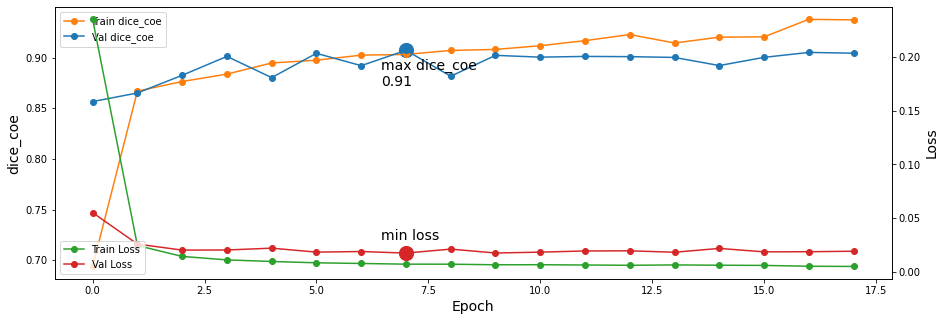

###################################
############ FOLD  2  #############
###################################
Image Size: 512, Batch Size: 80
Training Model Fold 2...
24/24 [==============================] - 4s 142ms/step - loss: 0.0098 - dice_coe: 0.9291 - accuracy: 0.9967


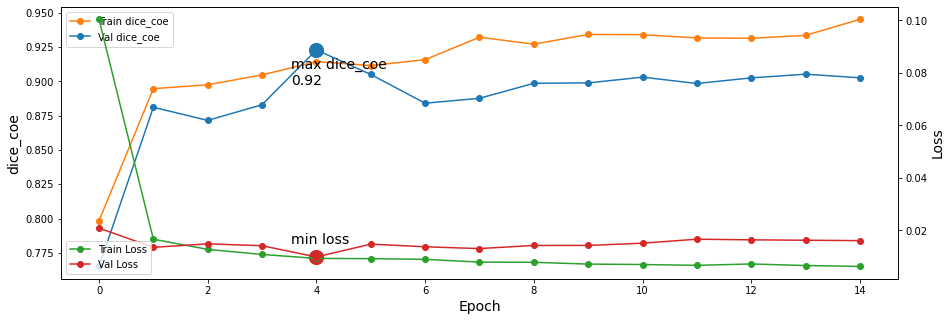

###################################
############ FOLD  3  #############
###################################
Image Size: 512, Batch Size: 80
Training Model Fold 3...
23/23 [==============================] - 4s 142ms/step - loss: 0.0096 - dice_coe: 0.9346 - accuracy: 0.9967


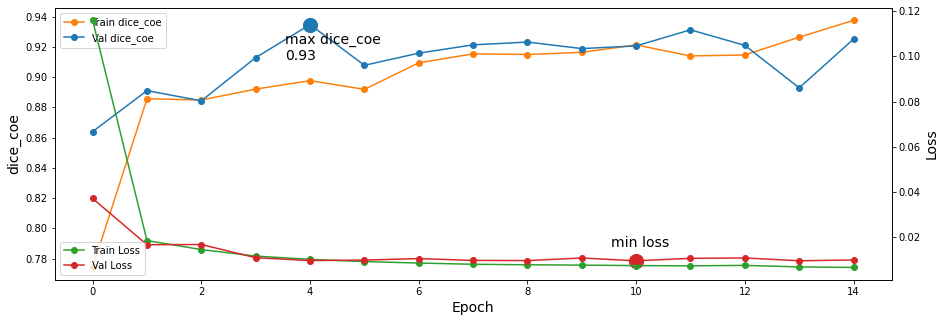

###################################
############ FOLD  4  #############
###################################
Image Size: 512, Batch Size: 80
Training Model Fold 4...
32/32 [==============================] - 6s 142ms/step - loss: 0.0099 - dice_coe: 0.9268 - accuracy: 0.9965


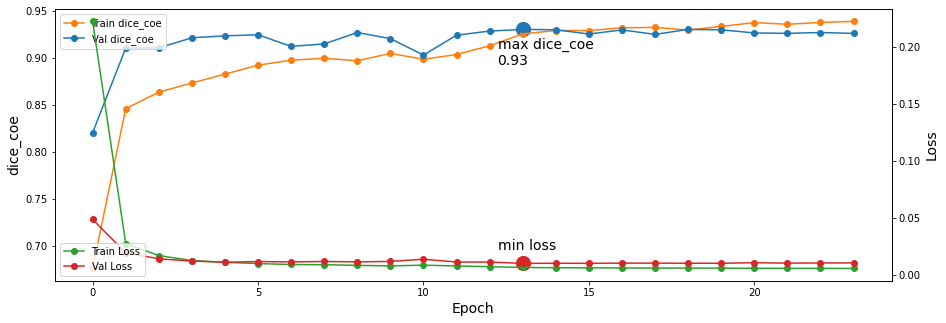

###################################
############ FOLD  5  #############
###################################
Image Size: 512, Batch Size: 80
Training Model Fold 5...
36/36 [==============================] - 6s 141ms/step - loss: 0.0153 - dice_coe: 0.8924 - accuracy: 0.9964


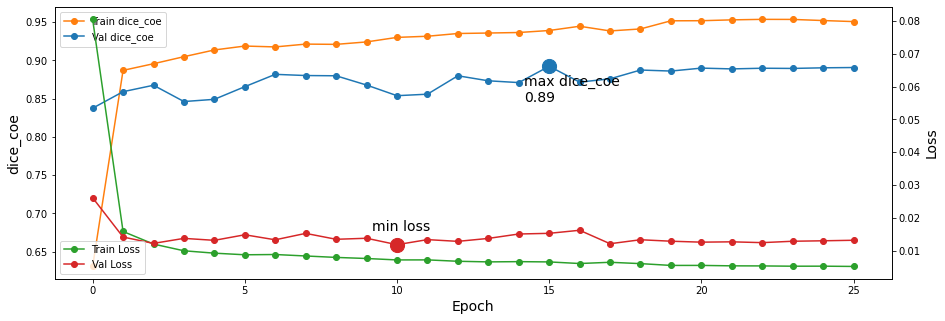

In [9]:
import os
from shutil import copyfile


M = {}
metrics = ['loss','dice_coe','accuracy']
for fm in metrics:
    M['val_'+fm] = []

fold = KFold(n_splits=P['NFOLDS'], shuffle=True, random_state=P['SEED'])
for fold,(tr_idx, val_idx) in enumerate(fold.split(ALL_TRAINING_FILENAMES)):
    
    print('#'*35); print('############ FOLD ',fold+1,' #############'); print('#'*35);
    print(f'Image Size: {DIM}, Batch Size: {BATCH_SIZE}')
    
#     if fold<3:
#         #already computed
#         srcWeight = "../input/halfb6/model-fold-"+str(fold)+".h5"
#         dstWeight = "./model-fold-"+str(fold)+".h5"
#         copyfile(srcWeight, dstWeight)
#         M['val_loss'].append(0.001)
#         M['val_dice_coe'].append(81.09)
#         M['val_accuracy'].append(99.99)
#         print("Files copied to current directory")
#         continue
        
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = [ALL_TRAINING_FILENAMES[fi] for fi in tr_idx]
    if P['OVERLAPP']:
        TRAINING_FILENAMES += [ALL_TRAINING_FILENAMES2[fi] for fi in tr_idx]
    
    VALIDATION_FILENAMES = [ALL_TRAINING_FILENAMES[fi] for fi in val_idx]
    STEPS_PER_EPOCH = P['STEPS_COE'] * count_data_items(TRAINING_FILENAMES) // BATCH_SIZE
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():   
        model = sm.Linknet(P['BACKBONE'], encoder_weights='imagenet')
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = P['LR']),
                      loss = tf.keras.losses.BinaryCrossentropy(),#'focal_tversky',
                      metrics=[dice_coe,'accuracy'])
        
    # CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model-fold-%i.h5'%fold,
                                 verbose=P['VERBOSE'],monitor='val_dice_coe',patience = 10,
                                 mode='max',save_best_only=True)
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coe',mode = 'max', patience=10, restore_best_weights=True)
    reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=0.00001)
        
    print(f'Training Model Fold {fold+1}...')
    history = model.fit(
        get_training_dataset(),
        epochs = P['EPOCHS'],
        steps_per_epoch = STEPS_PER_EPOCH,
        callbacks = [checkpoint, reduce,early_stop],
        validation_data = get_validation_dataset(),
        verbose=P['VERBOSE']
    )   
    
    #with strategy.scope():
    #    model = tf.keras.models.load_model('/kaggle/working/model-fold-%i.h5'%fold, custom_objects = {"dice_coe": dice_coe})
    
    # SAVE METRICS
    m = model.evaluate(get_validation_dataset(),return_dict=True)
    for fm in metrics:
        M['val_'+fm].append(m[fm])
    
    # PLOT TRAINING
    # https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords
    if P['DISPLAY_PLOT']:        
        plt.figure(figsize=(15,5))
        n_e = np.arange(len(history.history['dice_coe']))
        plt.plot(n_e,history.history['dice_coe'],'-o',label='Train dice_coe',color='#ff7f0e')
        plt.plot(n_e,history.history['val_dice_coe'],'-o',label='Val dice_coe',color='#1f77b4')
        x = np.argmax( history.history['val_dice_coe'] ); y = np.max( history.history['val_dice_coe'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max dice_coe\n%.2f'%y,size=14)
        plt.ylabel('dice_coe',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(n_e,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(n_e,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.legend(loc=3)
        plt.show()

In [10]:
### WRITE METRICS
import json
from datetime import datetime
M['datetime'] = str(datetime.now())
for fm in metrics:
    M['oof_'+fm] = np.mean(M['val_'+fm])
    print('OOF '+ fm + ' '+ str(M['oof_'+fm]))
with open('metrics.json', 'w') as outfile:
    json.dump(M, outfile)

OOF loss 0.012454818189144134
OOF dice_coe 0.917982017993927
OOF accuracy 0.9960816621780395
